In [2]:
import itertools
import os
import time

import numpy
import matplotlib.pyplot as plt

import cirq
import openfermion
import openfermioncirq as ofc
from openfermioncirq.optimization import OptimizationParams, ScipyOptimizationAlgorithm
from openfermionpyscf import run_pyscf



Warning

Modules in the "future" directory (dmrgscf, fciqmcscf, shciscf, icmspt, xianci)
have been moved to pyscf/pyscf directory.  You can still import these modules.
from the "future" directory, and they work the same as before.

To avoid name conflicts with python built-in module "future", this directory
will be deleted in future release.



ModuleNotFoundError: No module named 'future.utils'

In [ ]:
# Functions for generating molecular Hamiltonians
# -----------------------------------------------

def h2_geometry(bond_length):
    return [
        ('H', (0.0, 0.0, 0.0)),
        ('H', (0.0, 0.0, bond_length))
    ]


def n2_geometry(bond_length):
    return [
        ('N', (0.0, 0.0, 0.0)),
        ('N', (0.0, 0.0, bond_length))
    ]


def h2o_geometry(bond_length):
    bond_angle = numpy.pi * 104.5 / 180  # 104.5 degrees
    a = bond_length * numpy.cos(bond_angle / 2.0)
    b = bond_length * numpy.sin(bond_angle / 2.0)
    return [
        ('H', (a, b, 0.0)),
        ('H', (a, -b, 0.0)),
        ('O', (0.0, 0.0, 0.0))
    ]


def generate_molecular_hamiltonian(geometry,
                                   n_active_electrons,
                                   n_active_orbitals,
                                   basis='cc-pvdz',
                                   multiplicity=1):

    # Run electronic structure calculations
    molecule = run_pyscf(
        openfermion.hamiltonians.MolecularData(
            geometry, 
            basis,
            multiplicity
        )
    )

    # Freeze core orbitals and truncate to active space
    n_core_orbitals = (molecule.n_electrons - n_active_electrons) // 2
    occupied_indices = list(range(n_core_orbitals))
    active_indices = list(range(n_core_orbitals,
                                n_core_orbitals + n_active_orbitals))
    
    return molecule.get_molecular_hamiltonian(occupied_indices, active_indices)

In [ ]:
# Create or load a variational study
# ----------------------------------

# Set directory to save studies in
STUDIES_DIR = 'studies'


# Set Hamiltonian parameters
geometry_factory = h2_geometry
bond_length = 1.4
n_active_electrons = 2
n_active_orbitals = 2
hamiltonian_name = 'H2_cc-pvdz_singlet_1.4_2-2'


# Set ansatz parameters
ansatz_class = ofc.SwapNetworkTrotterAnsatz
iterations = 1
ansatz_kwargs = {'include_all_xxyy': True}


# Generate Hamiltonian
hamiltonian = generate_molecular_hamiltonian(
    geometry_factory(bond_length),
    n_active_electrons,
    n_active_orbitals
)


# Create or load study
study_name = '{}_{}_iterations{}'.format(
    hamiltonian_name, ansatz_class.__name__, iterations)

if os.path.isfile(os.path.join(STUDIES_DIR, '{}.study'.format(study_name))):
    # Load study
    study = ofc.VariationalStudy.load(
        study_name,
        datadir=STUDIES_DIR)
    print("LOADED a variational study with {} qubits and {} parameters.".format(
        len(study.ansatz.qubits), study.num_params))
else:
    # Create study
    # Generate ansatz and objective
    hamiltonian_ferm_op = openfermion.get_fermion_operator(hamiltonian)
    ansatz_hamiltonian = openfermion.get_diagonal_coulomb_hamiltonian(
        hamiltonian_ferm_op,
        ignore_incompatible_terms=True)
    ansatz = ansatz_class(
        ansatz_hamiltonian,
        iterations=iterations,
        **ansatz_kwargs)
    objective = ofc.HamiltonianObjective(hamiltonian)

    # Use preparation circuit for mean-field state
    preparation_circuit = cirq.Circuit.from_ops(
        ofc.prepare_gaussian_state(
            ansatz.qubits,
            openfermion.QuadraticHamiltonian(ansatz_hamiltonian.one_body),
            occupied_orbitals=range(n_active_electrons)))

    study = ofc.VariationalStudy(
        study_name,
        ansatz,
        objective,
        preparation_circuit=preparation_circuit,
        datadir=STUDIES_DIR)
    print("CREATED a variational study with {} qubits and {} parameters.".format(
        len(study.ansatz.qubits), study.num_params))

In [ ]:
# Perform optimization runs
# -------------------------

def cost_to_achieve_expected_noise(noise, variance):
    if noise == 0.0:
        return None
    return variance/noise**2 * 2/numpy.pi


def run_study(max_evaluations, noise_level):

    # Set the evaluation cost based on the desired noise level
    cost_of_evaluate = cost_to_achieve_expected_noise(
        noise_level,
        study.objective.variance_bound)
    
    # Define algorithms
    algorithms = [
        ScipyOptimizationAlgorithm(
            kwargs={'method': 'COBYLA'},
            options={'maxiter': max_evaluations,
                     'rhobeg': 0.2},
            uses_bounds=False
        ),
        ScipyOptimizationAlgorithm(
            kwargs={'method': 'L-BFGS-B'},
            options={'maxiter': max_evaluations,
                     'eps': 1e-4},
        ),
        ScipyOptimizationAlgorithm(
            kwargs={'method': 'Nelder-Mead'},
            options={'maxfev': max_evaluations,
                     'fatol': 1e-4},
            uses_bounds=False
        )
    ]

    optimization_params_and_identifiers = [
            (
                OptimizationParams(algorithm=algorithm,
                                   cost_of_evaluate=cost_of_evaluate),
                (algorithm.name, max_evaluations, noise_level)
            )
            for algorithm in algorithms
    ]

    repetitions = 10  # Number of times to repeat each optimization run
    use_multiprocessing = True
    num_processes = 10

    for params, identifier in optimization_params_and_identifiers:
        if identifier not in study.results:
            print('Performing optimization run {}.'.format(identifier))
            print(params)
            t0 = time.time()
            study.optimize(
                    optimization_params=params,
                    identifier=identifier,
                    reevaluate_final_params=True,
                    stateful=True,
                    repetitions=repetitions,
                    use_multiprocessing=use_multiprocessing,
                    num_processes=num_processes
            )
            t1 = time.time()
            elapsed_time = t1 - t0
            print('\tFinished after {} seconds.'.format(elapsed_time))
            study.save()
            
# Run optimizations
# -----------------

# Set parameters of interest
max_evaluation_nums = [50, 20, 10]
noise_levels = [0.0, 1e-4, 5e-4]

# Vary noise level
max_evaluations = 50
for noise_level in noise_levels:
    run_study(max_evaluations, noise_level)

# Vary max evaluations
noise_level = 1e-4
for max_evaluations in max_evaluation_nums:
    run_study(max_evaluations, noise_level)

In [5]:
# Functions for generating plots
# ------------------------------


def absolute_error(trial_result, target):
    return numpy.abs(trial_result.data_frame['optimal_value'] - target)


def success_probability(trial_result, target, precision):
    errors = absolute_error(trial_result, target)
    return numpy.count_nonzero(errors < precision) / trial_result.repetitions


def average_idle_time(trial_result):
    idle_times = [sum(result.wait_times) for result in trial_result.results]
    return numpy.mean(idle_times)


def circuit_execution_time(circuit, gate_time, measurement_time):
    return gate_time * len(circuit) + measurement_time


def experiment_time(circuit,
                    repetitions,
                    num_evaluations,
                    num_executions_per_evaluation,
                    gate_time,
                    measurement_time,
                    optimizer_time,
                    switch_time):
    return repetitions * (
        num_evaluations * (
            num_executions_per_evaluation
            * circuit_execution_time(circuit, gate_time, measurement_time)
            + switch_time
        )
    )

def plot_success(ax,
                 trial_results,
                 target,
                 precision,
                 label):
    success_probabilities = [success_probability(trial_result, target, precision)
                             for trial_result in trial_results]
    x_vals = range(len(trial_results))
    ax.plot(x_vals, success_probabilities, 'o-', label=label)


def plot_average_idle_time(ax,
                           trial_results,
                           label):
    average_idle_times = [average_idle_time(trial_result)
                          for trial_result in trial_results]
    x_vals = range(len(trial_results))
    ax.plot(x_vals, average_idle_times, 'o-', label=label)


def plot_experiment_time(ax,
                         trial_results,
                         target,
                         precision,
                         circuit,
                         gate_time,
                         measurement_time,
                         switch_time):
    experiment_times = []
    for trial_result in trial_results:
        success_prob = success_probability(trial_result, target, precision)
        repetitions = numpy.ceil(1 / success_prob)
        num_evaluations = numpy.mean([result.num_evaluations for result in trial_result.results])
        num_executions_per_evaluation = trial_result.params.cost_of_evaluate
        optimizer_time = average_idle_time(trial_result)
        experiment_time_in_seconds = experiment_time(
            circuit,
            repetitions,
            num_evaluations,
            num_executions_per_evaluation,
            gate_time,
            measurement_time,
            optimizer_time,
            switch_time
        )
        
        experiment_times.append(experiment_time_in_seconds / 3600)

    x_vals = range(len(trial_results))
    ax.plot(x_vals, experiment_times, 'o-')


def plot_error(ax,
               trial_results,
               target,
               labels):
    errors = [absolute_error(trial_result, target)
              for trial_result in trial_results]
    ax.boxplot(errors, vert=True, labels=labels)


def plot_time(ax,
              trial_results,
              labels):
    times = [trial_result.data_frame['time'] for trial_result in trial_results]
    ax.boxplot(times, vert=True, labels=labels)


def plot_wait_times(ax, result):
    ax.plot(range(len(result.wait_times)), result.wait_times)


def plot_function_values(ax, result):
    vals = [values[0] for values in result.function_values]
    ax.plot(range(len(vals)), vals)


def generate_success_vs_noise_plot(ax,
                                   study,
                                   algs,
                                   noise_levels,
                                   evals,
                                   target,
                                   precision):
    for alg in algs:
        trial_results = [study.results[(alg, evals, noise_level)] for noise_level in noise_levels]
        plot_success(ax,
                     trial_results,
                     target,
                     precision,
                     label=alg)

    ax.set_xticks(range(len(noise_levels)))
    ax.set_xticklabels([noise for noise in noise_levels])
    ax.set_xlabel('Expected noise in function evaluation')
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel('Success probability')
    ax.set_title('Probability of achieving precision {} with max evals {}'.format(precision, evals))
    ax.legend()


def generate_success_vs_max_evals_plot(ax,
                                       study,
                                       algs,
                                       eval_nums,
                                       noise_level,
                                       target,
                                       precision):
    for alg in algs:
        trial_results = [study.results[(alg, evals, noise_level)] for evals in eval_nums]
        plot_success(ax,
                     trial_results,
                     target,
                     precision,
                     label=alg)

    ax.set_xticks(range(len(eval_nums)))
    ax.set_xticklabels(eval_nums)
    ax.set_xlabel('Max function evaluations allowed')
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel('Success probability')
    ax.set_title('Probability of achieving precision {} with expected noise {}'.format(precision, noise_level))
    ax.legend()



def generate_average_idle_time_plot(ax,
                                    study,
                                    algs,
                                    eval_nums,
                                    noise_level):
    for alg in algs:
        trial_results = [study.results[(alg, evals, noise_level)] for evals in eval_nums]
        plot_average_idle_time(ax,
                               trial_results,
                               label=alg)

    ax.set_xticks(range(len(eval_nums)))
    ax.set_xticklabels(eval_nums)
    ax.set_xlabel('Max function evaluations allowed')
    ax.set_ylabel('Average idle time')
    ax.set_title('Average idle time with noise level {}'.format(noise_level))
    ax.legend()


def generate_experiment_time_plot(ax,
                                  study,
                                  alg,
                                  max_evaluation_nums,
                                  noise_levels,
                                  target,
                                  precision,
                                  gate_time,
                                  measurement_time,
                                  switch_time):
    trial_results = [study.results[(alg, max_evaluations, noise_level)]
                     for max_evaluations, noise_level
                     in itertools.product(max_evaluation_nums, noise_levels)]
    labels = [(max_evaluations, noise_level)
              for max_evaluations, noise_level
              in itertools.product(max_evaluation_nums, noise_levels)]
    plot_experiment_time(ax,
                         trial_results,
                         target,
                         precision,
                         study.circuit,
                         gate_time,
                         measurement_time,
                         switch_time)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel('(max evaluations, noise level)')
    ax.set_ylabel('Time (hours)')
    ax.set_title('Time to run complete experiment using {}'.format(alg))


def generate_error_plot(ax,
                        study,
                        algs,
                        noise_level,
                        target,
                        max_evaluations):

    trial_results = [study.results[(alg, max_evaluations, noise_level)] for alg in algs]
    plot_error(ax,
               trial_results,
               target,
               labels=algs)

    for tick in ax.get_xticklabels():
        tick.set_rotation(35)
    ax.set_ylabel('Error')
    ax.set_title('Algorithm errors with expected noise {}, max evals {}'.format(noise_level, max_evaluations))


def generate_time_plot(ax,
                       studies,
                       alg,
                       cost,
                       max_evaluations):

    trial_results = [study.results[(alg, max_evaluations, cost)] for study in studies]
    plot_time(ax,
              trial_results,
              labels=[study.num_params for study in studies])

    ax.set_xlabel('Number of parameters')
    ax.set_ylabel('Time')
    ax.set_title('Time spent on optimization by {}, max evals {}'.format(alg, max_evaluations))


def generate_wait_time_plot(ax,
                            result,
                            alg):
    plot_wait_times(ax, result)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Wait time')
    ax.set_title('Time elapsed between successive queries for {}'.format(alg))


def generate_function_value_plots(ax,
                                  result,
                                  alg):
    plot_function_values(ax, result)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Function values')
    ax.set_title('Function values queried by {}'.format(alg))

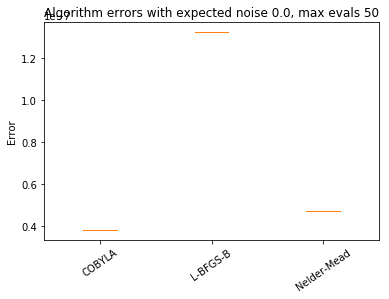

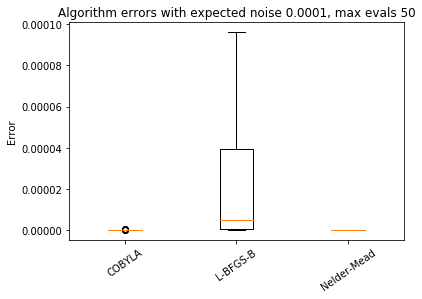

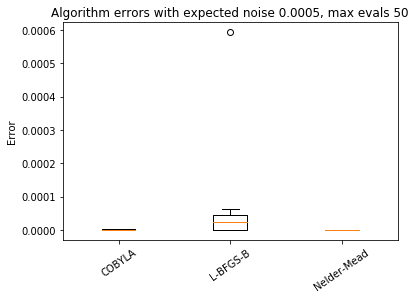

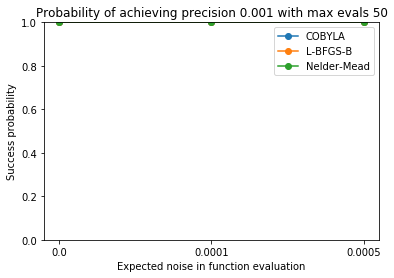

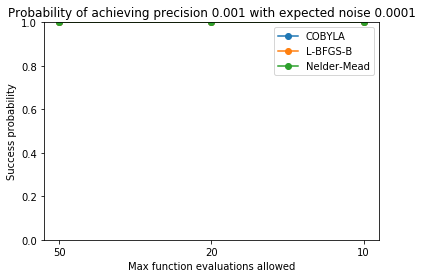

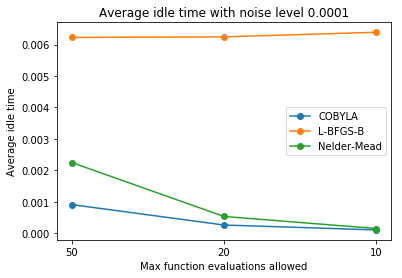

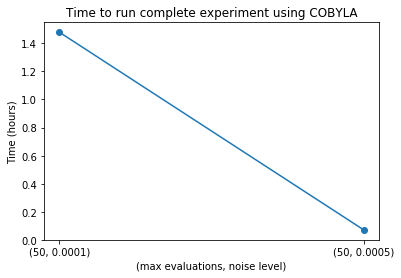

In [10]:
algs = ['COBYLA', 'L-BFGS-B', 'Nelder-Mead']
noise_levels = [0.0, 1e-4, 5e-4]
max_evaluation_nums = [50, 20, 10]

gate_time = 3e-8
measurement_time = 5e-7
switch_time = 1.0


# Use this function to compare to the optimal value found by optimizations
def optimal_value(study):
    return min(trial_result.optimal_value for trial_result in study.results.values())


# Use this function to compare to the true ground energy we want
def target_value(study):
    hamiltonian_sparse = openfermion.get_sparse_operator(study.objective.hamiltonian)
    energy, _ = openfermion.get_ground_state(hamiltonian_sparse)
    return energy


for i, noise_level in enumerate(noise_levels):
    fig, ax = plt.subplots(1, 1)
    generate_error_plot(ax, study, algs, noise_level, optimal_value(study), 50)

fig, ax = plt.subplots(1, 1)
generate_success_vs_noise_plot(ax, study, algs, noise_levels, 50, optimal_value(study), 1e-3)

fig, ax = plt.subplots(1, 1)
generate_success_vs_max_evals_plot(ax, study, algs, max_evaluation_nums, 1e-4, optimal_value(study), 1e-3)

fig, ax = plt.subplots(1, 1)
generate_average_idle_time_plot(ax, study, algs, max_evaluation_nums, 1e-4)

fig, ax = plt.subplots(1, 1)
generate_experiment_time_plot(ax,
                              study,
                              'COBYLA',
                              [50],
                              [1e-4, 5e-4],
                              optimal_value(study),
                              1e-3,
                              gate_time,
                              measurement_time,
                              switch_time)


plt.show()

Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs s

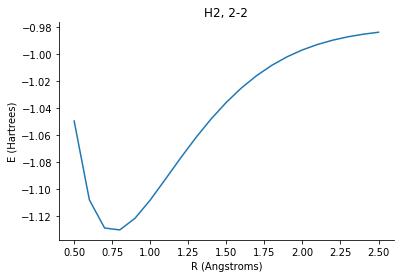

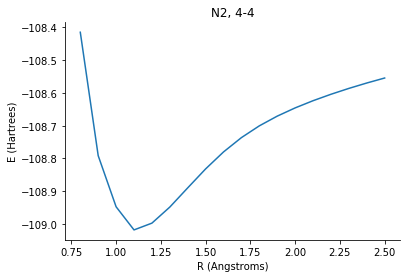

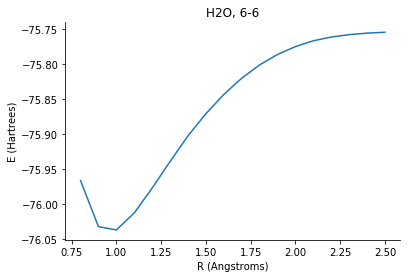

In [11]:
# Plot some energy diagrams

def plot_energies(ax,
                  bond_lengths,
                  hamiltonian_factory):
    energies = []
    for bond_length in bond_lengths:
        hamiltonian = hamiltonian_factory(bond_length)
        hamiltonian_sparse = openfermion.get_sparse_operator(hamiltonian)
        energy, _ = openfermion.get_ground_state(hamiltonian_sparse)
        energies.append(energy)
    
    ax.set_xlabel(r'R (Angstroms)')
    ax.set_ylabel(r'E (Hartrees)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.plot(bond_lengths, energies)


h2_bond_lengths = numpy.arange(0.5, 2.6, 0.1)
n2_bond_lengths = numpy.arange(0.8, 2.6, 0.1)
h2o_bond_lengths = numpy.arange(0.8, 2.6, 0.1)

fig, ax = plt.subplots(1, 1)
plot_energies(ax,
              h2_bond_lengths,
              lambda b: generate_molecular_hamiltonian(h2_geometry(b), 2, 2))
ax.set_title('H2, 2-2')

fig, ax = plt.subplots(1, 1)
plot_energies(ax,
              n2_bond_lengths,
              lambda b: generate_molecular_hamiltonian(n2_geometry(b), 4, 4))
ax.set_title('N2, 4-4')

fig, ax = plt.subplots(1, 1)
plot_energies(ax,
              h2o_bond_lengths,
              lambda b: generate_molecular_hamiltonian(h2o_geometry(b), 6, 6))
ax.set_title('H2O, 6-6')

plt.show()